In [63]:
import pandas as pd
from pymoo.optimize import minimize

#%matplotlib qt
from pyreport import PlotUtil
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "example_data.h5"

row_limit = -1

store_500km = pd.HDFStore(file_path)

instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_500km_df = instances_500km_df.sort_index(0)

In [65]:
N_passes = 20

instances_df = instances_500km_df.loc[0:N_passes,:]

In [66]:
from problems.link_budget_problem import LinkBudgetProblem
from notebooks.optimization_problems.design_vector import design_vector_default_scm, SystemParameters

sys_param = SystemParameters()
sys_param.margin_dB = 0.0
problem = LinkBudgetProblem(instances_df, sys_param)

sampling, crossover, mutation = design_vector_default_scm(problem.x_length, problem.x_indices)

converge_algo_settings = {'pop_size': 100, 'n_offsprings': 40}
unconverge_algo_settings = {'pop_size': 100, 'n_offsprings': 20}

converge_term_settings = {'f_tol': 0.0001, 'n_max_gen': 1000, 'n_max_evals': 10000}
unconverge_term_settings =  {'f_tol': 0.005, 'n_max_gen': 100, 'n_max_evals': 2000}

converge = True
if converge:
    algo_settings = converge_algo_settings
    term_settings = converge_term_settings
    postfix = '_converged'
else:
    algo_settings = unconverge_algo_settings
    term_settings = unconverge_term_settings
    postfix = '_unconverged'

from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    #x_tol=1e-8,
    #cv_tol=1e-6,
    f_tol=term_settings['f_tol'], #f_tol=0.005,
    nth_gen=5,
    n_last=30,
    n_max_gen=term_settings['n_max_gen'], #n_max_gen=1000,
    n_max_evals=term_settings['n_max_evals'], #n_max_evals=100000
)

from pymoo.algorithms.nsga2 import NSGA2

algorithm = NSGA2(
    pop_size=algo_settings['pop_size'],
    n_offsprings=algo_settings['n_offsprings'],
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True,
)

res = minimize(problem,
               algorithm,
               termination=termination,
               seed=1,
               save_history=True,
               #verbose=True
               )


print('Processes:', res.exec_time)
print("Best solution found: %s" % res.X)

C:\git\hermes-optimization\cenv\lib\site-packages\pymoo\operators\mutation\polynomial_mutation.py:34: RuntimeWarning: invalid value encountered in true_divide
  delta1 = (X - xl) / (xu - xl)
C:\git\hermes-optimization\cenv\lib\site-packages\pymoo\operators\mutation\polynomial_mutation.py:35: RuntimeWarning: invalid value encountered in true_divide
  delta2 = (xu - X) / (xu - xl)


Processes: 20.024487733840942
Best solution found: [[False False False ... 28.225456446537027 20.0 0]
 [True True False ... 16.22239594657635 20.0 0]
 [False True False ... 23.36255380318672 20.0 0]
 ...
 [False True False ... 24.268265146165497 20.0 0]
 [False True False ... 29.61312515783472 20.0 0]
 [False False False ... 29.61312515783472 20.0 0]]


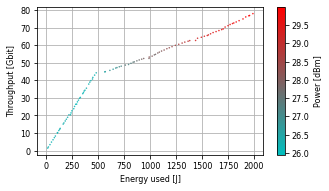

In [67]:
real_power = True

from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm

isend_req = 10.69

fig = plt.figure(figsize=(3.2, 2.4))

ax = fig.add_subplot(1,1,1)
ax.grid()
ax.set_axisbelow(True)

x_power = res.X[:, problem.x_indices['power']]
x_power = x_power[:,0]

f_energy = res.F[:,1]
f_throughput = ((res.F[:,0] * -1) / 1e9)   # Gigabit

cm1 = mcol.LinearSegmentedColormap.from_list("BlueRed",["c","r"])

min_Ptx = min(x_power)
max_Ptx = max(x_power)

cnorm = mcol.Normalize(vmin=min_Ptx,vmax=max_Ptx)

cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])

cc = cpick.to_rgba(x_power.tolist())
ax.scatter(f_energy, f_throughput, c=cc, marker='.', s=1)

ax.set_xlabel("Energy used [J]")
ax.set_ylabel("Throughput [Gbit]")
cb = plt.colorbar(cpick,label="Power [dBm]")
cb.ax.tick_params(labelsize=8)
cb.ax.yaxis.label.set_size(8)
PlotUtil.apply_report_formatting(4.72, 2.76)
plt.tight_layout()

fig.savefig('D:/git/thesis_report_ae/figures/link_budget_pareto%s.pdf' % postfix)
#plt.savefig('D:/git/thesis_report_ae/figures/link_budget_pareto%s.svg' % postfix)
plt.show()
plt.close()

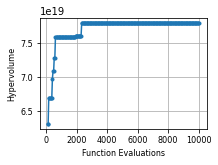

In [68]:
fig = plt.figure(figsize=(3.2, 2.4))

import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([0,1e9]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# function evaluations at each snapshot
n_evals = np.array([a.evaluator.n_eval for a in res.history])

# visualze the convergence curve
plt.plot(n_evals, hv, '-o', markersize=3)
#plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
PlotUtil.apply_report_formatting()
plt.tight_layout()
plt.grid()
#plt.savefig('D:/git/thesis_report_ae/figures/link_budget_hypervolume%s.svg' % postfix)
fig.savefig('D:/git/thesis_report_ae/figures/link_budget_hypervolume%s.pdf' % postfix)
plt.show()
plt.close()
